In [1]:
import random as rd
import numpy as np
import math as mt
from matplotlib import pyplot as plt
import pandas as pdb

## Functions

### Lattice

In [2]:
def count(lattice, length):
    n_count = 0
    g_count = 0
    s_count = 0
    t_count = 0
    b_count = 0

    for i in range(length):
        for j in range(length):
            if lattice[j][i] == 0:
                s_count += 1
            elif 1 >= lattice[j][i] >= 0.5:
                t_count += 1
            elif 0.5 > lattice[j][i] > 0:
                g_count += 1
            elif lattice[j][i] > 1:
                n_count += 1
            else:
                b_count += 1  # negative numbers

    m_sum = s_count + t_count + g_count + n_count + b_count
    print("Source:", s_count)
    print("Tolerant: ", t_count)
    print("Gullible: ", g_count)
    # print("Neutral: ", n_count)
    # print("b_count", b_count)
    print("TOTAL", m_sum)
    return


def lattice_initialize(lattice, length, coverage):
    counter = 0  # main counter
    gullible_counter = 0
    tolerant_counter = 0
    maximum = length ** 2 - 1

    max_gullible = maximum * coverage
    max_tolerant = maximum - 1 - max_gullible

    while counter < maximum:
        # guess random position
        xs = rd.choice(range(length))
        ys = rd.choice(range(length))
        v = rd.triangular()
        # print(v, counter, tolerant_counter, gullible_counter, xs, ys)

        if lattice[ys][xs] == 10000:
            if v > 0.5 and tolerant_counter < max_tolerant:
                lattice[ys][xs] = v
                tolerant_counter += 1
                counter += 1
            elif v < 0.5 and gullible_counter < max_gullible:
                lattice[ys][xs] = v
                gullible_counter += 1
                counter += 1

    count(lattice, length)
    np.savetxt("Initial Population " + str(coverage) + ".csv", lattice, delimiter = ",")  # Save init Population to csv
    return lattice


def gullible_counter(lattice, length):
    counter = 0
    for i in range(length):
        for j in range(length):
            if lattice[j][i] < 0.5 and lattice[j][i] != 0:
                counter += 1
    return counter


def count_source(lattice, length):
    counter = 0
    for i in range(length):
        for j in range(length):
            if lattice[j][i] == 0:
                counter += 1
    return counter


def tolerant_counter(lattice, length):
    counter = 0
    for i in range(length):
        for j in range(length):
            if 0.5 <= lattice[j][i] < 1:
                counter += 1
    return counter


### Lattice Update

In [3]:
def main_equation(value, x, y, i, j, multiplier):
    alpha = rd.triangular()
    out = value + multiplier * (-alpha * (1/(mt.sqrt(((x - i)**2 + (y - j)**2)))))
    return out


def update_lattice_equation(lattice, length, initial_n, time, decay_constant):
    for i in range(length):
        for j in range(length):
            if lattice[j][i] == 0:

                multi = initial_n * (mt.exp(-time / decay_constant))
                
                try:  # below the source
                    lattice[j+1][i] = main_equation(lattice[j + 1][i], i, j, i, j+1, multi)
                    # print("1")
                except IndexError:
                    pass

                try:  # above the source
                    lattice[j-1][i] = main_equation(lattice[j + 1][i], i, j, i, j-1, multi)
                    # print("2")
                except IndexError:
                    pass

                try:  # right to the source
                    lattice[j][i+1] = main_equation(lattice[j + 1][i], i, j, i + 1, j, multi)
                    # print("3")
                except IndexError:
                    pass

                try:  # left to the source
                    lattice[j][i-1] = main_equation(lattice[j + 1][i], i, j, i - 1, j, multi)
                    # print("4")
                except IndexError:
                    pass

                try:  # diagonal down and right
                    lattice[j+1][i + 1] = main_equation(lattice[j + 1][i], i, j, i+1, j+1, multi)
                    # print(5)
                except IndexError:
                    pass

                try:  # diagonal down and left
                    lattice[j+1][i-1] = main_equation(lattice[j + 1][i], i, j, i-1, j+1, multi)
                    # print("6")
                except IndexError:
                    pass

                try:  # diagonal up and right
                    lattice[j-1][i+1] = main_equation(lattice[j + 1][i], i, j, i+1, j-1, multi)
                    # print("7")
                except IndexError:
                    pass

                try:  # diagonal up and left
                    lattice[j-1][i-1] = main_equation(lattice[j + 1][i], i, j, i-1, j-1, multi)
                    # print("9")
                except IndexError:
                    pass

    for i in range(length):
        for j in range(length):
            if lattice[j][i] < 0:
                lattice[j][i] = 0

    return lattice


def update_matrix_equation(lattice, decay_constant, initial_n, length, time, x0, y0):  # Equation Based Approach
    multiplier = initial_n * (mt.exp(-time / decay_constant))

    for i in range(length):
        for j in range(length):
            if i != x0 and j != y0:
                alpha = rd.triangular()
                lattice[j][i] = lattice[j][i] + multiplier * (-alpha * 1 / (mt.sqrt(((x0 - i) ** 2 + (y0 - j) ** 2))))

    for i in range(length):
        for j in range(length):
            if lattice[j][i] < 0:
                lattice[j][i] = 0

    return lattice


## Program

In [4]:
decay_const: int = 1
n_0 = 1
repeat = 10

In [5]:
main_source = {}
main_gullible = {}
main_tolerant = {}
main_step = []

for i in range(repeat):
    source50 = []
    gullible50 = []
    tolerant50 = []
    
    check = True
    step = 0
    n = 100    # length of the matrix
    N = np.full(shape=(n, n), fill_value=10000, dtype=np.float32)  # creates matrix will all values having 10000
    tm = 0  # time

    source_counter = 0
    max_source = (n**2) * 0.9  # stopping criteria

    xs = 50
    ys = 50

    # xs = rd.choice(range(n))  # initial x and y for the source, (value == 0)
    # ys = rd.choice(range(n))

    N[ys][xs] = 0
    
    lattice_initialize(N, n, 0.50)

    while check == True:
        update_lattice_equation(N, n, n_0, 1, decay_const)
        source50.append(count_source(N, n))
        tolerant50.append(tolerant_counter(N, n))
        gullible50.append(gullible_counter(N, n))
        tm += 1

        if tm > 200:
            if source50[tm-1] == source50[tm-2] and source50[tm-2] == source50[tm-3] and source50[tm-3] == source50[tm-4] and source50[tm-4] == source50[tm-5] and source50[tm-5] == source50[tm-6]:
                check = False

    np.savetxt("Final_Population_50_" + str(i) + ".csv", N, delimiter = ",")
    
    main_source[str(i)] = source50
    main_gullible[str(i)] = gullible50
    main_tolerant[str(i)] = tolerant50
    
    print('Iteration Number: ', i)
    print('END-----------------------------------------END')

Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Iteration Number:  0
END-----------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Iteration Number:  1
END-----------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Iteration Number:  2
END-----------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Iteration Number:  3
END-----------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Iteration Number:  4
END-----------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Iteration Number:  5
END-----------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Iteration Number:  6
END-----------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Iteration Number:  7
END-----------------------------------------END
Source: 1
Tolera

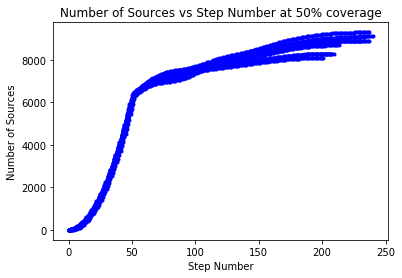

In [9]:
for i in range(repeat):
    plt.plot(range(len(main_source[str(i)])), main_source[str(i)], 'b.-')
plt.ylabel('Number of Sources')
plt.xlabel('Step Number')
plt.title('Number of Sources vs Step Number at 50% coverage')
#plt.savefig('50_source.png', bbox_inches='tight')
plt.show()

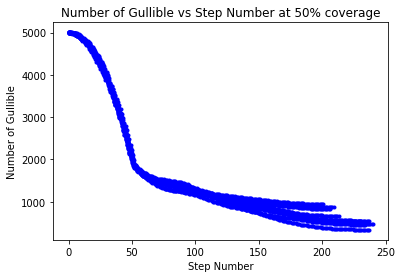

In [10]:
for i in range(repeat):
    plt.plot(range(len(main_gullible[str(i)])), main_gullible[str(i)], 'b.-')
plt.ylabel('Number of Gullible')
plt.xlabel('Step Number')
plt.title('Number of Gullible vs Step Number at 50% coverage')
#plt.savefig('50_Gullible.png', bbox_inches='tight')
plt.show()

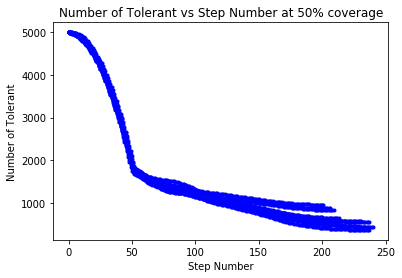

In [11]:
for i in range(repeat):
    plt.plot(range(len(main_tolerant[str(i)])), main_tolerant[str(i)], 'b.-')
plt.ylabel('Number of Tolerant')
plt.xlabel('Step Number')
plt.title('Number of Tolerant vs Step Number at 50% coverage')
#plt.savefig('50_tolerant.png', bbox_inches='tight')
plt.show()